# belief testing

rendere il belief indipendente dalla posizione e orientazione del robot, dipenderò unicamente dalla deformazione

$$b(s=((x,y,phi),theta)) = b(theta) * \delta(xyphi = real(xyphi))$$

real(xyphi) = x*
from now on x = xyphi


## belief update 

$$b'_{a,o}(x',\theta') = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot \sum_{x,\theta}p(x',\theta'|x,\theta,a)b(x,\theta)$$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot b(x'-a,\theta') $$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot \delta (x'-a = x^* )b(\theta') $$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot b(\theta') $$

dunque a seconda della azione scelta i non zero saranno i 4 x raggiungibili con a

$$p(o|b,a) = \sum_{x,\theta}p(o|x,\theta)b(x.\theta)$$
$$ = \sum_{\theta}p(o|x^*,\theta)b(\theta)$$

immagino la struttura di input per la rete come qualcosa del tipo x,y,phi,b(theta)=[b(theta1),b(theta2),b(theta3),b(theta4)]

è vero che possiamo rendere indipendenti pos e theta per le transizioni, ma non per le osservazioni né per il reward

In [8]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt

from agents.dqn import DoubleDQNAgent
from environment.env import GridEnvDeform
from eval import eval_agent




In [4]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 10
l1 = 1
h1 = 10

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
positions = [(x,y,phi) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4)]
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
position_dict = {position: i for i, position in enumerate(positions)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenP = len(positions)
lenA = len(actions)
lenO = len(obs)


# MDP eval

In [ ]:
Q = np.load("agents/tabularQ_maze_2_100k.npy")

# Infotxis

# Information Directed Sampling IDS

In [18]:
from agents.infotaxis import IDS, ThetaInfotaxis

agent = IDS(env)
# agent = ThetaInfotaxis(env)

In [19]:
transitions, beliefs = eval_agent("POMDP",agent,env, num_episodes=5,max_episode_steps=30, render=False)

100%|██████████| 5/5 [03:40<00:00, 44.14s/it]


Completed episodes: 1, out of 20


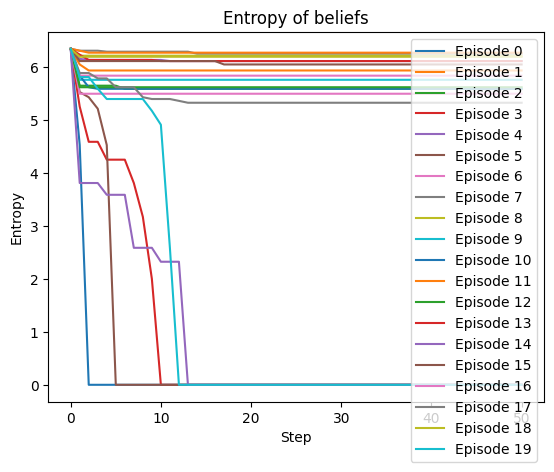

In [ ]:
def all_data(transitions, beliefs):
    # stats on transitions
    completed_episodes = 0
    for i in range(len(transitions)):
        if transitions[i][-1][1] == 1:
            completed_episodes += 1

    print(f"Completed episodes: {completed_episodes}, out of {len(transitions)}")

    def get_entropy(probabilities):
        
        # Calculate entropy, avoiding log(0) by adding a mask
        entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
        
        return entropy.item()  # .item() to get a standard Python float

    # plot entropy of beliefs 
    belief_entropy = [[get_entropy(belief) for belief in beliefs_episode] for beliefs_episode in beliefs]
    [plt.plot(belief_entropy[i]) for i in range(len(belief_entropy))]

    # multiple line plot
    plt.title("Entropy of beliefs")
    plt.xlabel("Step")
    plt.ylabel("Entropy")
    plt.legend([f"Episode {i}" for i in range(len(belief_entropy))])
    plt.show()

all_data(transitions, beliefs)

In [83]:
completed_episodes = 0
for i in range(len(transitions)):
    if transitions[i][-1][1] == 1:
        completed_episodes += 1

print(f"Completed episodes: {completed_episodes}, out of {len(transitions)}")

Completed episodes: 0, out of 5


In [84]:
def get_entropy(probabilities):
    
    # Calculate entropy, avoiding log(0) by adding a mask
    entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
    
    return entropy.item()  # .item() to get a standard Python float


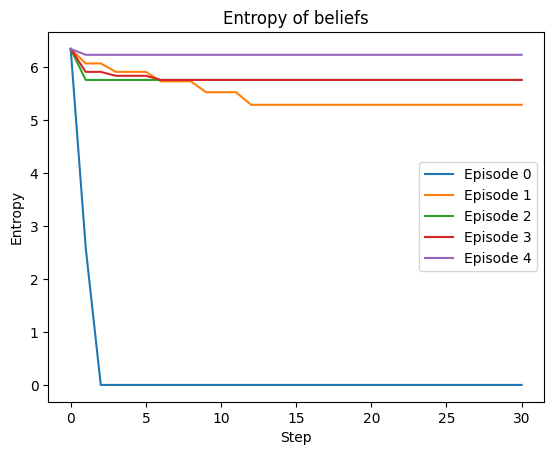

In [85]:

belief_entropy = [[get_entropy(belief) for belief in beliefs_episode] for beliefs_episode in beliefs]
# plot entropy of beliefs 
[plt.plot(belief_entropy[i]) for i in range(len(belief_entropy))]

# multiple line plot
plt.title("Entropy of beliefs")
plt.xlabel("Step")
plt.ylabel("Entropy")
plt.legend([f"Episode {i}" for i in range(len(belief_entropy))])
plt.show()


In [75]:
import time

# transitions[i] = [(s,a,s',o)....()...] for i-th episode

# replay buffer for episode i = succession of states
episode = 4
replay_episode = [t[0] for t in transitions[episode]] 


env.set_rendering()

for i, s in enumerate(replay_episode):
    env.set_state(s)
    env.render_bis()
    time.sleep(0.5)
    
env.close_render()

error: display Surface quit

# QMDP tabular

In [14]:
# import the MDP solution model (tabular q in this case)
Q = np.load(f"agents/tabularQ_maze_{N}_10deformations.npy")

In [15]:
from agents.tabular_qlearning import Q_agent, Thompson_agent
    
qagent = Q_agent(Q,env)
agent = Thompson_agent(Q,env)


In [16]:
transitions, beliefs = eval_agent("POMDP",qagent ,env, num_episodes=20,max_episode_steps=50,render=False)

100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


In [ ]:
env.set_rendering()
while True:
    try:
        env.render_bis()
    except:
        break

# DQN 

In [18]:
agent = DoubleDQNAgent(5,4)
agent.load("agents/double_dqn_maze_2_10deformations.pt")

/home/flaccagora/Desktop/RoboSurgery/src/agents/dqn.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_network.load_state_dict(torch.load(path))


In [19]:
eval_agent("POMDP",agent,env, num_episodes=1,max_episode_steps=25, render=True)

TypeError: b_theta_update() missing 1 required positional argument: 'observation'

In [5]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10,render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        
        obs = env.get_observation()

        b_0 = torch.ones(len(thetas)) / len(thetas)   
        b = b_theta_update(b_0,s[0], obs)
    
        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            if render:
                env.render()                                
            
            
            pos = s[0]
            theta = thetas[torch.argmax(b)]
            argmaxstate = (pos,theta)
            maxstate = torch.tensor([item for sublist in argmaxstate for item in sublist], dtype=torch.float32)

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(maxstate)
            next_state, reward, done, _, info = env.step(action,s,execute=render)

            next_obs = env.get_observation(next_state)
            s = next_state

            b_prime = b_theta_update(b,s[0], next_obs)
            b = b_prime

            if render:
                print("State: ", s)
                print("Chosen action: ", action)
                print("Next state: ", next_state)
                print("argmaxstate", argmaxstate)
                print("argmax and max Belief: ", thetas[torch.argmax(b_prime)], torch.max(b_prime))
                
            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


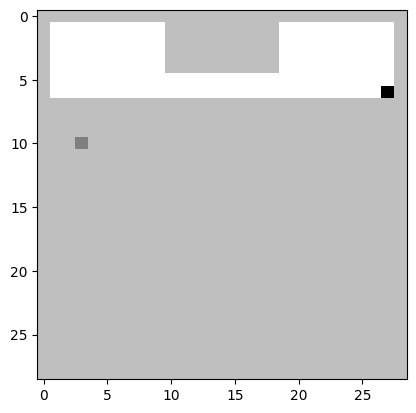

State:  ((9, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((9, 3, 0), (9, 2))
argmaxstate ((10, 3, 0), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0556)


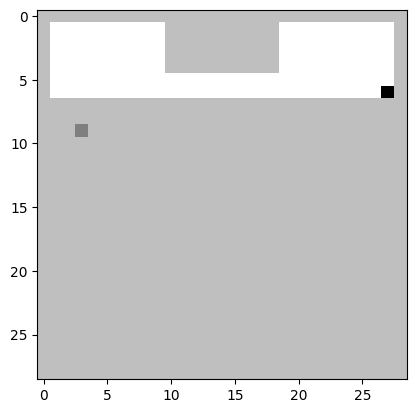

State:  ((8, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((8, 3, 0), (9, 2))
argmaxstate ((9, 3, 0), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0556)


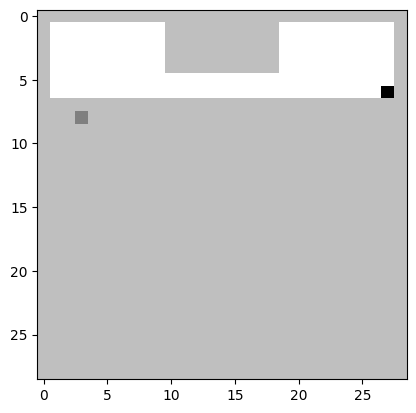

State:  ((7, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((7, 3, 0), (9, 2))
argmaxstate ((8, 3, 0), (1, 1))
argmax and max Belief:  (2, 2) tensor(0.1250)


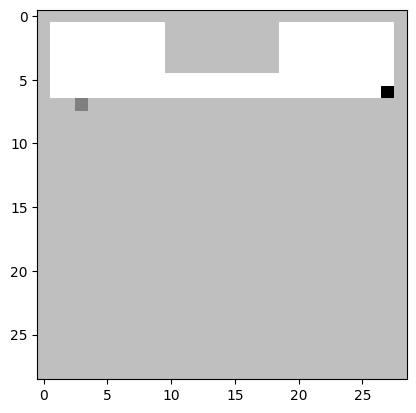

State:  ((6, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((6, 3, 0), (9, 2))
argmaxstate ((7, 3, 0), (2, 2))
argmax and max Belief:  (2, 2) tensor(0.1250)


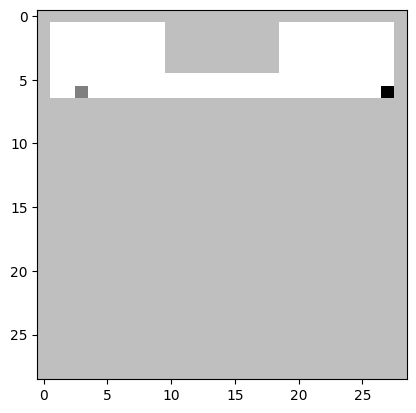

State:  ((5, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((5, 3, 0), (9, 2))
argmaxstate ((6, 3, 0), (2, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


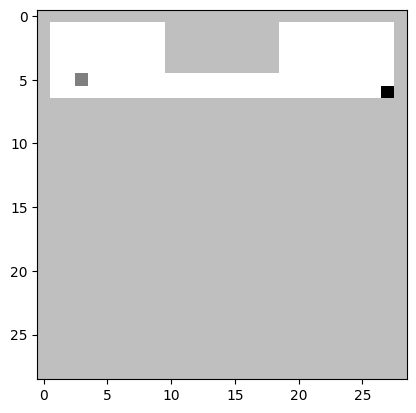

State:  ((4, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((4, 3, 0), (9, 2))
argmaxstate ((5, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


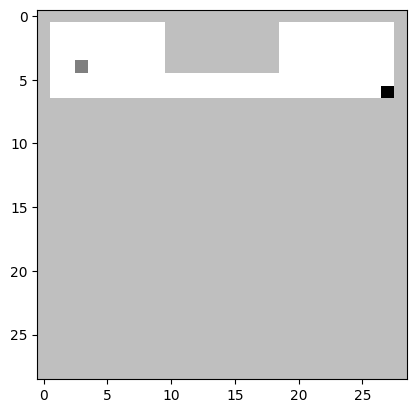

State:  ((3, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((3, 3, 0), (9, 2))
argmaxstate ((4, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


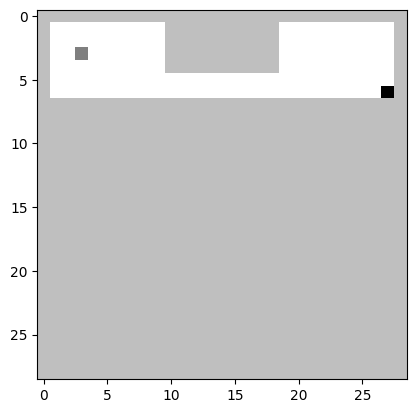

State:  ((2, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((2, 3, 0), (9, 2))
argmaxstate ((3, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


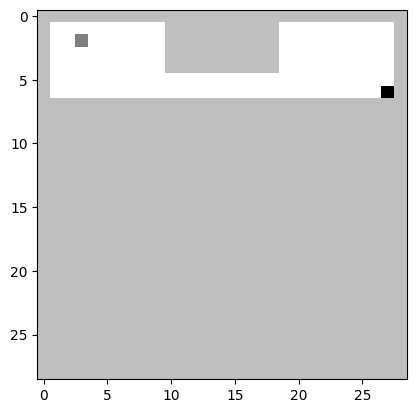

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((2, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


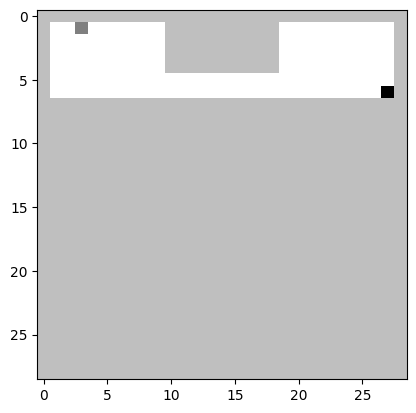

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


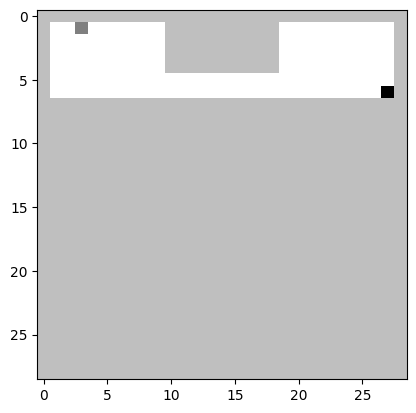

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


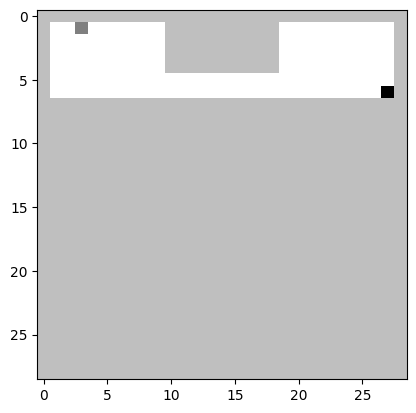

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


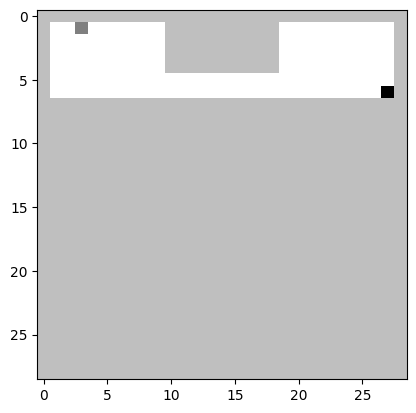

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


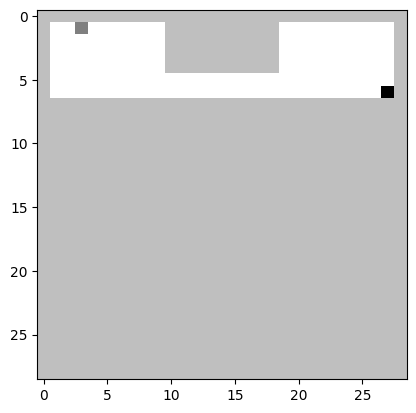

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


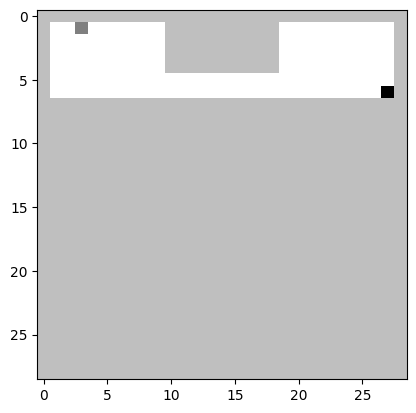

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


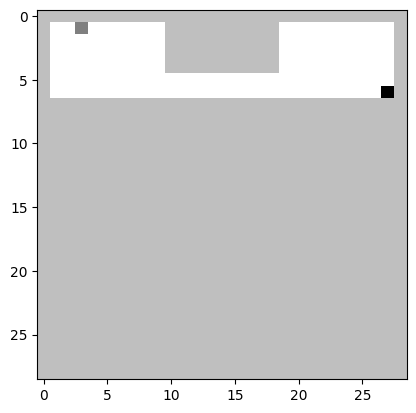

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


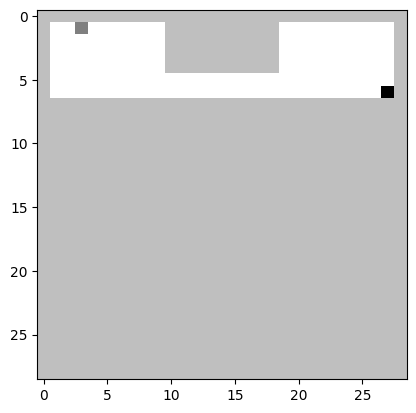

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


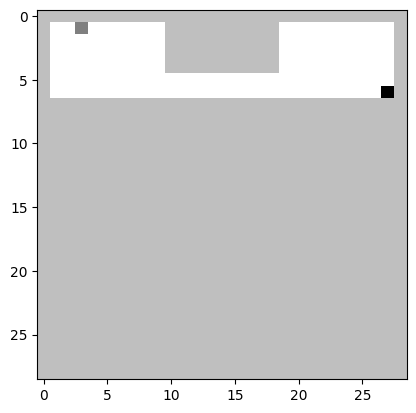

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


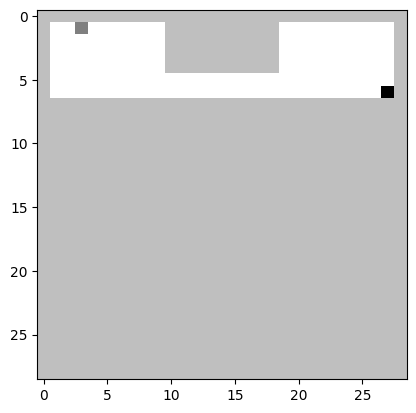

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


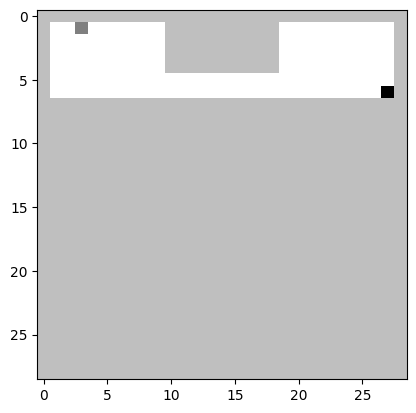

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


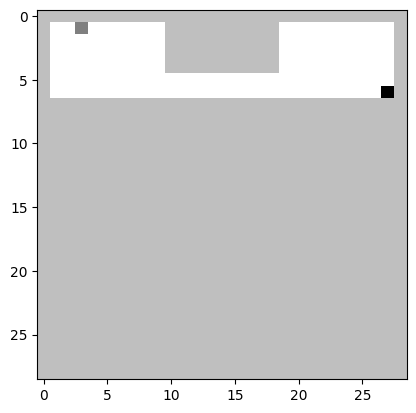

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


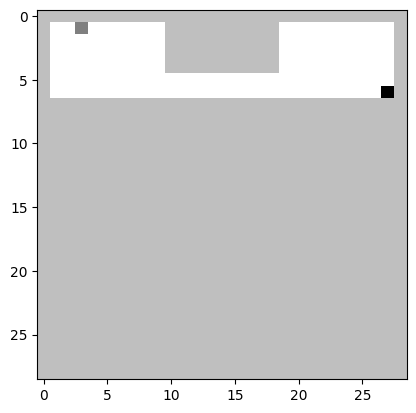

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


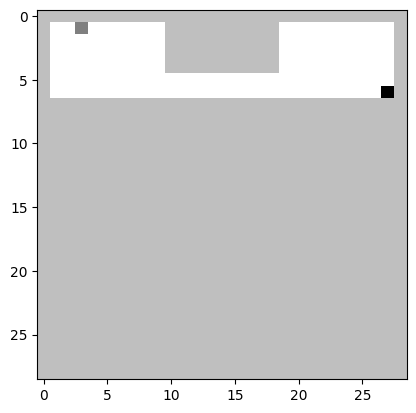

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


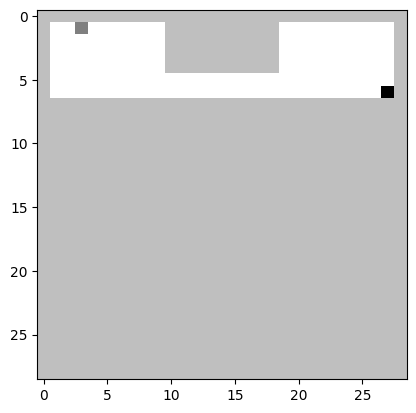

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


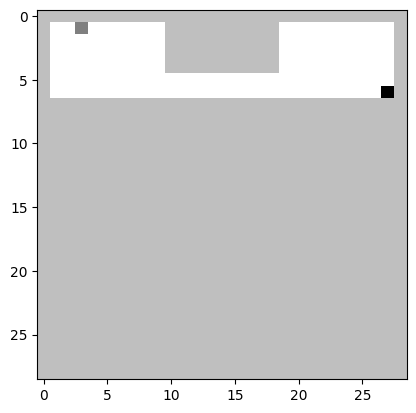

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


np.float64(-25.0)

In [6]:
evaluate_agent_training(env, agent,1,render=True)
